# Executed Notebook Analyses (RQ5, RQ6)

This notebooks analyzes the selection of executed notebooks. These analyses answer RQ5 and RQ6.

In [1]:
import sys
sys.path.insert(0, '../archaeology')

import re

from collections import Counter

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import analysis_helpers, importlib
importlib.reload(analysis_helpers)

from analysis_helpers import relative_var, cell_distribution
from analysis_helpers import dbmt, DBMT, print_relative_var_group
from analysis_helpers import load_vars, group_run, dbmt_relative_var
from analysis_helpers import dbmt_prepare_selectors, fig, savefig
from db import connect

%matplotlib inline

## Query

Select notebook aggregated data from:
- valid
  
  ```NOT (n.kernel = 'no-kernel' AND n.nbformat = '0')
  AND n.processed & 15 = 0 AND n.skip & (1024 + 512) = 0```


- non-duplicated
  
  ```n.skip & (1024 + 512 + 128) = 0```
  
- executed notebooks

  ```n.max_execution_count > -0```
  

In [2]:
%%time
with connect() as session:
    print("Query Meta Aggregate")
    executed_meta = pd.read_sql("""
        SELECT n.id, n.id as notebook_id, a.cells_outputs_text, a.cells_outputs_html, 
        a.cells_outputs_image, a.cells_outputs_error,
        a.cells_outputs_markdown, a.cells_outputs_extension,
        a.cells_outputs_pdf, a.cells_outputs_stream, a.cells_outputs_any,
        n.stargazers, n.forks, n.starforks
        FROM notebooks n, notebooks_fullexecmeta_aggregates a
        WHERE NOT (n.kernel = 'no-kernel' AND n.nbformat = '0')
        AND n.processed & 15 = 0
        AND n.skip & 2048 = 0
        AND n.skip & (1024 + 512) = 0
        AND n.skip & (1024 + 512 + 128) = 0
        AND n.max_execution_count > -0
        AND n.id = a.notebook_id
    """, session.connection())

Query Meta Aggregate
CPU times: user 4.09 s, sys: 357 ms, total: 4.44 s
Wall time: 2min 10s


In [3]:
%%time
with connect() as session:
    print("Query Bool Aggregate")
    executed_bool = pd.read_sql("""
        SELECT n.id, n.id as notebook_id, n.total_cells, n.code_cells, n.code_cells_with_output,
        n.non_executed_cells, n.actual_empty_cells, n.empty_cells_end, n.empty_cells_middle,
        b.outputs_any, b.outputs_text, b.outputs_html,
        b.outputs_image, b.outputs_error, b.outputs_markdown,
        b.outputs_extension, b.outputs_pdf, b.outputs_stream,
        n.stargazers, n.forks, n.starforks
        FROM notebooks n, notebooks_fullexecbool_aggregates b
        WHERE NOT (n.kernel = 'no-kernel' AND n.nbformat = '0')
        AND n.processed & 15 = 0
        AND n.skip & 2048 = 0
        AND n.skip & (1024 + 512) = 0
        AND n.skip & (1024 + 512 + 128) = 0
        AND n.max_execution_count > -0
        AND n.id = b.notebook_id
    """, session.connection())

Query Bool Aggregate
CPU times: user 4.12 s, sys: 249 ms, total: 4.37 s
Wall time: 17.7 s


In [4]:
%%time
BINS = 1261
cell_type_bins_arrays = {
    key: {
        'exe_executed': np.zeros(BINS),
        'exe_blank': np.zeros(BINS),
        'exe_empty': np.zeros(BINS),
    } for key, _ in DBMT + [(None, '<deleted>')]
}

with connect() as session:
    print("Query Bins")
    bin_arrays = session.execute("""
        SELECT n.id as notebook_id, m.bins_exe_executed, m.bins_exe_blank, bins_exe_empty,
        n.stargazers, n.forks, n.starforks
        FROM notebooks n, notebooks_meta_aggregates m
        WHERE NOT (n.kernel = 'no-kernel' AND n.nbformat = '0')
        AND n.processed & 15 = 0
        AND n.skip & 2048 = 0
        AND n.skip & (1024 + 512) = 0
        AND n.skip & (1024 + 512 + 128) = 0
        AND n.max_execution_count > -0
        AND m.notebook_id = n.id
    """)
    get_selectors = dbmt_prepare_selectors()
    for row in bin_arrays:
        selectors = get_selectors(row)

        if len(row.bins_exe_executed) > 1:
            for selector in selectors:
                cell_type_bins_arrays[selector]['exe_executed'] += np.array(row.bins_exe_executed)
        if len(row.bins_exe_blank) > 1:
            for selector in selectors:
                cell_type_bins_arrays[selector]['exe_blank'] += np.array(row.bins_exe_blank)
        if len(row.bins_exe_empty) > 1:
            for selector in selectors:
                cell_type_bins_arrays[selector]['exe_empty'] += np.array(row.bins_exe_empty)
    print("Executed notebooks:", len(executed_meta), len(executed_bool))

Query Bins
Executed notebooks: 932381 932381
CPU times: user 4min 19s, sys: 5.11 s, total: 4min 24s
Wall time: 14min 12s
Compiler : 269 ms
Parser   : 197 ms


In [5]:
notebooks = executed_meta.set_index("id").join(executed_bool.set_index("id"), rsuffix="b_")
notebooks.head(5)

,notebook_id,cells_outputs_text,cells_outputs_html,cells_outputs_image,cells_outputs_error,cells_outputs_markdown,cells_outputs_extension,cells_outputs_pdf,cells_outputs_stream,cells_outputs_any,...,outputs_html,outputs_image,outputs_error,outputs_markdown,outputs_extension,outputs_pdf,outputs_stream,stargazersb_,forksb_,starforksb_
id,,,,,,,,,,,,,,,,,,,,,
52869,52869,7,7,0,0,0,0,0,0,8,...,True,False,False,False,False,False,False,2,2,2.000000
367556,367556,0,0,0,0,0,0,0,1,1,...,False,False,False,False,False,False,True,1,2,1.333333
626048,626048,6,0,5,0,0,0,0,0,6,...,False,True,False,False,False,False,False,597,39,73.216981
727636,727636,30,6,0,2,0,0,0,18,42,...,True,False,True,False,False,False,True,1,3,1.500000
630460,630460,2,1,1,0,0,0,0,0,2,...,True,True,False,False,False,False,False,1,1,1.000000


In [6]:
total_code_cells = notebooks.code_cells.sum()

## Output Formats

### Cells with outputs

In [7]:
dbmt_relative_var(
    "{} of code cells from executed notebooks had output", "a4_executed_cells_with_outputs",
    dbmt(notebooks), dbmt(notebooks), 
    fn=lambda notebooks: notebooks["cells_outputs_any"].sum(),
    fn2=lambda notebooks: notebooks.code_cells.sum()
)


a4_executed_cells_with_outputs of code cells from executed notebooks had output


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"10,310,314 (54.31%)",None,None,None,None,None
1,(Sample),sd_,839 (53.54%),0.01%,0.00%,98.59%,(-) 1.41%,-0.76%
2,(Popular),td_,"340,385 (59.66%)",3.30%,1.79%,109.86%,(+) 9.86%,5.36%


In [8]:
def calculate_cell_counter(notebooks, prefix):
    return Counter({
        "Stream": notebooks["cells_outputs_stream"].sum().astype(int),
        "Text": notebooks["cells_outputs_text"].sum().astype(int),
        "HTML/JS": notebooks["cells_outputs_html"].sum().astype(int),
        "Image": notebooks["cells_outputs_image"].sum().astype(int),
        "Error": notebooks["cells_outputs_error"].sum().astype(int),
        "Formatted": notebooks["cells_outputs_markdown"].sum().astype(int),
        "Extension": notebooks["cells_outputs_extension"].sum().astype(int),
        "PDF": notebooks["cells_outputs_pdf"].sum().astype(int),
    })
cell_counter = group_run(dbmt(notebooks), DBMT, calculate_cell_counter, plot=False)
cell_counter

[Counter({'Stream': 3720076,
          'Text': 7022609,
          'HTML/JS': 1673722,
          'Image': 2336857,
          'Error': 235283,
          'Formatted': 126078,
          'Extension': 45726,
          'PDF': 8654}),
 Counter({'Stream': 261,
          'Text': 623,
          'HTML/JS': 162,
          'Image': 162,
          'Error': 19,
          'Formatted': 0,
          'Extension': 1,
          'PDF': 0}),
 Counter({'Stream': 150842,
          'Text': 199050,
          'HTML/JS': 41122,
          'Image': 67540,
          'Error': 3918,
          'Formatted': 4445,
          'Extension': 1103,
          'PDF': 279})]

### Notebooks with outputs

In [9]:
dbmt_relative_var(
    "{} executed notebooks had output in at least one cell", "a4_executed_notebooks_with_outputs",
    dbmt(notebooks[notebooks["outputs_any"]]), dbmt(notebooks)
)

a4_executed_notebooks_with_outputs executed notebooks had output in at least one cell


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"896,944 (96.20%)",None,None,None,None,None
1,(Sample),sd_,63 (98.44%),0.01%,0.01%,102.33%,(+) 2.33%,2.24%
2,(Popular),td_,"31,340 (95.49%)",3.49%,3.36%,99.26%,(-) 0.74%,-0.71%


In [10]:
def calculate_notebook_counter(notebooks, prefix):
    return Counter({
        "Stream": len(notebooks[notebooks["outputs_stream"]]),
        "Text": len(notebooks[notebooks["outputs_text"]]),
        "HTML/JS": len(notebooks[notebooks["outputs_html"]]),
        "Image": len(notebooks[notebooks["outputs_image"]]),
        "Error": len(notebooks[notebooks["outputs_error"]]),
        "Formatted": len(notebooks[notebooks["outputs_markdown"]]),
        "Extension": len(notebooks[notebooks["outputs_extension"]]),
        "PDF": len(notebooks[notebooks["outputs_pdf"]]),
    })
notebook_counter = group_run(dbmt(notebooks), DBMT, calculate_notebook_counter, plot=False)
notebook_counter

[Counter({'Stream': 657006,
          'Text': 764573,
          'HTML/JS': 344210,
          'Image': 481951,
          'Error': 138559,
          'Formatted': 17764,
          'Extension': 14544,
          'PDF': 1083}),
 Counter({'Stream': 48,
          'Text': 53,
          'HTML/JS': 33,
          'Image': 31,
          'Error': 11,
          'Formatted': 0,
          'Extension': 1,
          'PDF': 0}),
 Counter({'Stream': 21425,
          'Text': 22059,
          'HTML/JS': 8854,
          'Image': 14312,
          'Error': 2272,
          'Formatted': 575,
          'Extension': 320,
          'PDF': 35})]

### Table

In [11]:
def calculate_formats(data, prefix):
    notebooks, cell_counter, notebook_counter = data
    total_with_output = notebooks["cells_outputs_any"].sum()
    common = cell_counter.most_common()
    formats = pd.DataFrame(
        [(c/total_with_output, notebook_counter[n]/len(notebooks)) for n, c in common],
        index=[n for n, c in common],
        columns=["% of cells with output", "% of executed notebooks"]
    )
    formats.index.name = 'Format'
    formats.reset_index(level=0, inplace=True)
    display(formats.style.format({
        '% of cells with output': '{0:.2%}',
        '% of executed notebooks': '{0:.2%}'
        }))
    return formats
formats = group_run(zip(dbmt(notebooks), cell_counter, notebook_counter), DBMT, calculate_formats, plot=False)

,Format,% of cells with output,% of executed notebooks
0,Text,68.11%,82.00%
1,Stream,36.08%,70.47%
2,Image,22.67%,51.69%
3,HTML/JS,16.23%,36.92%
4,Error,2.28%,14.86%
5,Formatted,1.22%,1.91%
6,Extension,0.44%,1.56%
7,PDF,0.08%,0.12%


,Format,% of cells with output,% of executed notebooks
0,Text,74.26%,82.81%
1,Stream,31.11%,75.00%
2,HTML/JS,19.31%,51.56%
3,Image,19.31%,48.44%
4,Error,2.26%,17.19%
5,Extension,0.12%,1.56%
6,Formatted,0.00%,0.00%
7,PDF,0.00%,0.00%


,Format,% of cells with output,% of executed notebooks
0,Text,58.48%,67.21%
1,Stream,44.32%,65.28%
2,Image,19.84%,43.61%
3,HTML/JS,12.08%,26.98%
4,Formatted,1.31%,1.75%
5,Error,1.15%,6.92%
6,Extension,0.32%,0.97%
7,PDF,0.08%,0.11%


In [12]:
def create_output_table_tex(formats, prefix):
    with open("outputs/{}a4_output_table.tex".format(prefix), "w") as fil:
        fil.write(formats.to_latex(index=False, formatters={
            '% of cells with output': '{0:.2%}'.format,
            '% of executed notebooks': '{0:.2%}'.format
        }))
group_run(formats, DBMT, create_output_table_tex, plot=False)

dbmt_relative_var(
    "Notebooks with image: {}", "a4_notebooks_with_image",
    notebook_counter, dbmt(notebooks),
    fn=lambda notebook_counter: notebook_counter['Image']
)

Notebooks with image: a4_notebooks_with_image


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"481,951 (51.69%)",None,None,None,None,None
1,(Sample),sd_,31 (48.44%),0.01%,0.00%,93.71%,(-) 6.29%,-3.25%
2,(Popular),td_,"14,312 (43.61%)",2.97%,1.53%,84.36%,(-) 15.64%,-8.08%


In [13]:
mixed = pd.merge(formats[0], formats[-1], on="Format")
mixed.columns = pd.MultiIndex.from_tuples([
    ("", "", "Format"), ("Overall", "% of cells", "with output"), ("Overall", "% of executed", "notebooks"),
    ("Popular", "% of cells", "with output"), ("Popular", "% of executed", "notebooks")
])
with open("outputs/d_td_a4_output_table.tex", "w") as fil:
    fil.write(mixed.to_latex(index=False, multicolumn_format="c", column_format="lcccc", formatters=[
        '{}'.format,
        '{0:.2%}'.format,
        '{0:.2%}'.format,
        '{0:.2%}'.format,
        '{0:.2%}'.format,
    ]))
mixed

Overall                   Popular              
              % of cells % of executed  % of cells % of executed
      Format with output     notebooks with output     notebooks
0       Text    0.681125      0.820022    0.584779      0.672100
1     Stream    0.360811      0.704654    0.443151      0.652783
2      Image    0.226652      0.516903    0.198422      0.436062
3    HTML/JS    0.162335      0.369173    0.120810      0.269766
4      Error    0.022820      0.148608    0.011510      0.069224
5  Formatted    0.012228      0.019052    0.013059      0.017519
6  Extension    0.004435      0.015599    0.003240      0.009750
7        PDF    0.000839      0.001162    0.000820      0.001066

## Cell Distribution

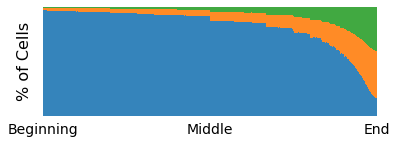

(Sample) 


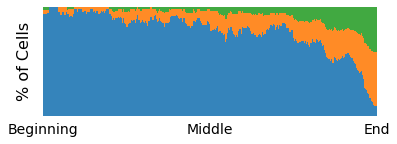

(Popular) 


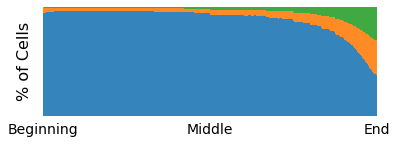

[None, None, None]

In [14]:
def execution_distribution(cell_type_bins_arrays, prefix):
    select = ["exe_executed", "exe_blank", "exe_empty"]
    with cell_distribution(prefix + "a4_execution_distribution", 6, 2, select, BINS - 1, cell_type_bins_arrays) as ax:
        #ax.annotate("executed", xy=(30, 20), color="white", weight="bold")
        #ax.annotate("no-exec", xy=(1020, 45), rotation=-35, color="white", weight="bold")
        #ax.annotate("empty", xy=(1050, 90), color="white", weight="bold")
        ax.set_ylim(0, 100)

group_run([cell_type_bins_arrays[prefix] for prefix, _ in DBMT], DBMT, execution_distribution)

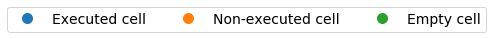

In [15]:


with savefig("a4_execution_distribution_legend", 8, 0.3):
    texts = ["Executed cell", "Non-executed cell", "Empty cell"]
    colors = ["tab:blue", "tab:orange", "tab:green"]
    patches = [ plt.plot([],[], marker="o", ms=10, ls="", mec=None, color=colors[i], 
                label="{:s}".format(texts[i]) )[0]  for i in range(len(texts)) ]
    plt.legend(handles=patches, bbox_to_anchor=(0.5, 0.5), 
               loc='center', ncol=3, numpoints=1 )
    ax = plt.gca()
    ax.axis("off")


## Notebook Execution Characteristics

In [16]:
dbmt_relative_var(
    "Notebooks with non-executed cells: {}", "a4_notebooks_with_non_executed_cells", 
    dbmt(notebooks[notebooks["non_executed_cells"] > 0]),
    dbmt(notebooks)
)

Notebooks with non-executed cells: a4_notebooks_with_non_executed_cells


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"196,797 (21.11%)",None,None,None,None,None
1,(Sample),sd_,20 (31.25%),0.01%,0.00%,148.06%,(+) 48.06%,10.14%
2,(Popular),td_,"4,265 (12.99%)",2.17%,0.46%,61.57%,(-) 38.43%,-8.11%


In [17]:
dbmt_relative_var(
    "Notebooks with empty cells: {}", "a4_notebooks_with_empty_cells",
    dbmt(notebooks[notebooks["actual_empty_cells"] > 0]), dbmt(notebooks)
)

Notebooks with empty cells: a4_notebooks_with_empty_cells


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"579,416 (62.14%)",None,None,None,None,None
1,(Sample),sd_,40 (62.50%),0.01%,0.00%,100.57%,(+) 0.57%,0.36%
2,(Popular),td_,"12,334 (37.58%)",2.13%,1.32%,60.47%,(-) 39.53%,-24.56%


In [18]:
dbmt_relative_var(
    "Notebooks with empty cells in the end: {}", "a4_notebooks_with_empty_end", 
    dbmt(notebooks[notebooks["empty_cells_end"] > 0]), dbmt(notebooks)
)

Notebooks with empty cells in the end: a4_notebooks_with_empty_end


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"551,503 (59.15%)",None,None,None,None,None
1,(Sample),sd_,40 (62.50%),0.01%,0.00%,105.66%,(+) 5.66%,3.35%
2,(Popular),td_,"11,881 (36.20%)",2.15%,1.27%,61.20%,(-) 38.80%,-22.95%


In [19]:
dbmt_relative_var(
    "Notebooks with empty cells among non-empty ones: {}", "a4_notebooks_with_empty_cells_among_non_empty", 
    dbmt(notebooks[notebooks["empty_cells_middle"] > 0]), dbmt(notebooks)
)

Notebooks with empty cells among non-empty ones: a4_notebooks_with_empty_cells_among_non_empty


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"105,828 (11.35%)",None,None,None,None,None
1,(Sample),sd_,7 (10.94%),0.01%,0.00%,96.36%,(-) 3.64%,-0.41%
2,(Popular),td_,"1,634 (4.98%)",1.54%,0.18%,43.86%,(-) 56.14%,-6.37%


This notebook analyzed general characteristics of notebooks and cells to answer RQ5 and RQ6 for the paper. There are other analyses that did no make into the paper. For those, refer to E2.Notebooks and E6.Cells.